In [1]:
import os
import math
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 8

In [2]:
load_app_config()
DIRECTORY="bike_sharing"
TESTFILE ='test.csv'
TRAINFILE ='train.csv'
PREDICTOR="total"
input_path = get_datafolder_path()

{'REG': {'ML_DATASOURCE': 'F:\\DataSource', 'ML_PATH': 'F:\\MachineLearning'}, 'DEV': {'ML_DATASOURCE': 'F:\\DataSource', 'ML_PATH': 'F:\\MachineLearning'}, 'PRD': {'ML_DATASOURCE': 'F:\\DataSource', 'ML_PATH': 'F:\\MachineLearning'}, 'UAT': {'ML_DATASOURCE': 'F:\\DataSource', 'ML_PATH': 'F:\\MachineLearning'}}
Adding F:\DataSource  to system path
Adding F:\MachineLearning  to system path


In [3]:
def load_dataset(filename=TRAINFILE,predictor=PREDICTOR):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    #input_dataset = load_data(input_file)
    input_dataset = pd.read_csv(input_file, parse_dates=True)
    input_dataset.rename(columns={'count':'total'}, inplace=True)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    predictor_column =  [col for col in input_dataset.columns if predictor in col]
    feature_columns =  [col for col in input_dataset.columns if predictor not in col]
    
    return continuous_vars ,categorical_vars,predictor_column,feature_columns,input_dataset

In [17]:
def transform_dataset(continuous_vars ,categorical_vars,input_dataset):
    output_dataset = input_dataset
    season_dummies = pd.get_dummies(input_dataset['season'], prefix='season')
    # print 5 random rows
    season_dummies.sample(n=5, random_state=1)
    # drop the first column
    season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)
    # print 5 random rows
    season_dummies.sample(n=5, random_state=1)
    output_dataset = pd.concat([output_dataset, season_dummies], axis=1)
    output_dataset["hour"] = [t.hour for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset["day"] = [t.dayofweek for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset["month"] = [t.month for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset['year'] = [t.year for t in pd.DatetimeIndex(output_dataset.datetime)]
    output_dataset['year'] = output_dataset['year'].map({2011:0, 2012:1})
    temp =pd.DatetimeIndex(output_dataset['datetime'])
    output_dataset['weekday'] = temp.weekday
    #hour_dummies = pd.get_dummies(output_dataset['hour'], prefix='hour')
    #hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
    #output_dataset = pd.concat([output_dataset, hour_dummies], axis=1)
    output_dataset['daytime'] = ((output_dataset['hour'] > 6) & (output_dataset['hour'] < 21)).astype(int)
    # print 5 random rows
    output_dataset.sample(n=5, random_state=1)
    output_dataset.drop('atemp',axis =1)
    
    for col in ['casual', 'registered', 'total']:
        output_dataset['log-' + col] = output_dataset[col].apply(lambda x: np.log1p(x))
    
    return output_dataset

In [5]:
def plot_dataset(X,y,feature_columns,predictor_column,train_dataset):
    fig = plt.figure(figsize=(20,20))
    X_rows,X_cols = X.shape 
    for i in range(X_cols):
        if(feature_columns[i]!='datetime'):
            ax = fig.add_subplot(7, 3, i + 1)
            ax.scatter(train_dataset.iloc[:,i],y,marker=".")
            ax.set_title("{0} vs {1}".format(feature_columns[i],predictor_column))
            plt.tight_layout()
    plt.show()

 input file is :F:\DataSource\bike_sharing\train.csv loaded.
Continous Variables
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'total'],
      dtype='object')
Categorical Variables
Index(['datetime'], dtype='object')
 input file is :F:\DataSource\bike_sharing\test.csv loaded.
Continous Variables
Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed'],
      dtype='object')
Categorical Variables
Index(['datetime'], dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'total',
       'season_2', 'season_3', 'season_4', 'hour', 'day', 'month', 'year',
       'weekday', 'daytime', 'log-casual', 'log-registered', 'log-total'],
      dtype='object')


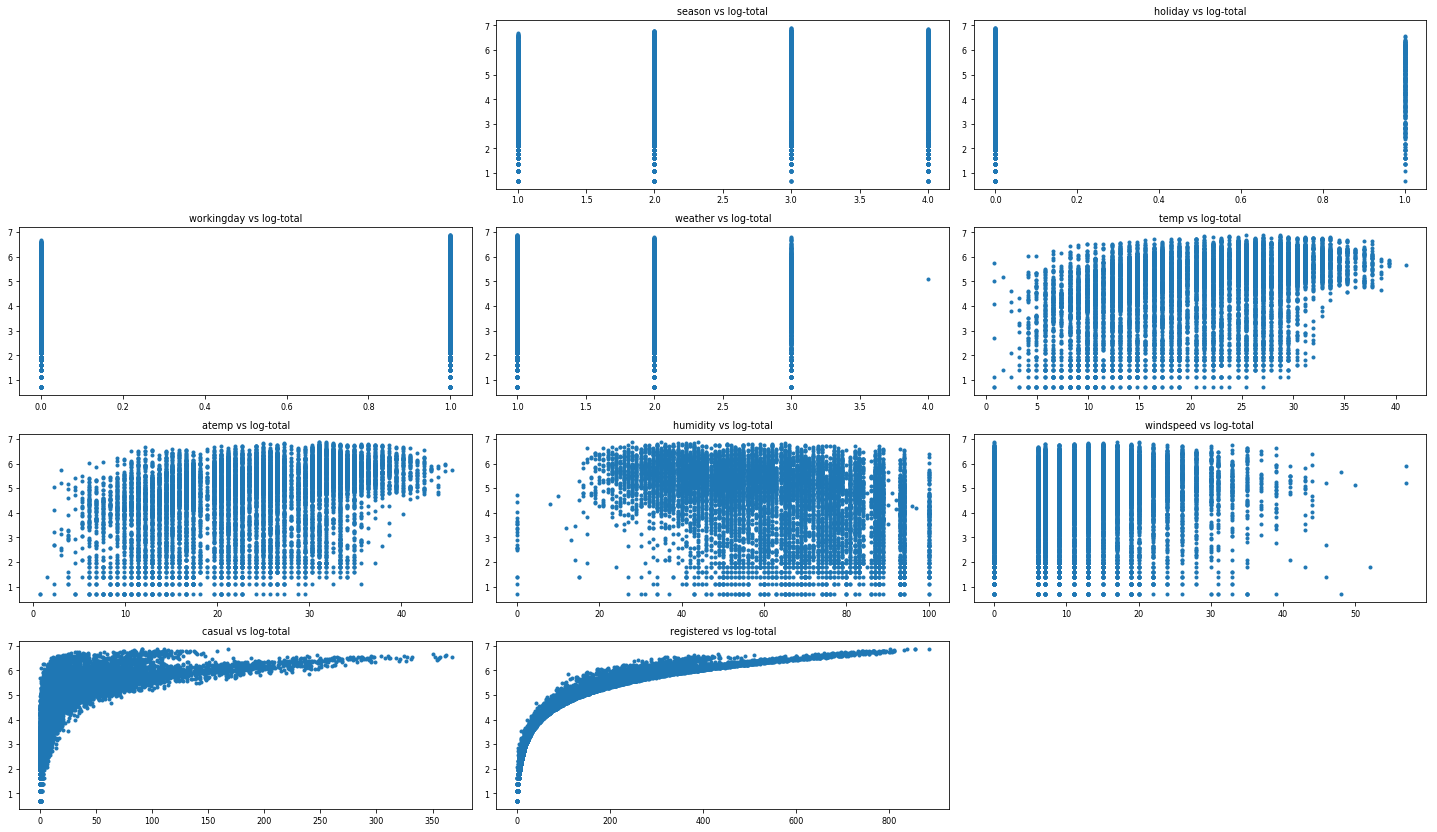

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: weekday, dtype: int64


In [18]:
(continuous_vars ,categorical_vars,predictor_column,feature_columns,train_dataset ) = load_dataset(TRAINFILE,PREDICTOR)
(tecontinuous_vars ,tecategorical_vars,tepredictor_column,tefeature_columns,test_dataset ) = load_dataset(TESTFILE,PREDICTOR)
predictor_column = "log-total"

train_dataset = transform_dataset(continuous_vars ,categorical_vars,train_dataset)
test_dataset = transform_dataset(continuous_vars ,categorical_vars,train_dataset)
print(train_dataset.columns)
y=train_dataset[predictor_column]
X =train_dataset[['season', 'holiday', 'workingday', 'weather','temp','humidity', 'windspeed', 'year', 'month', 'weekday', 'hour']]
plot_dataset(X,y,feature_columns,predictor_column,train_dataset)
print(X['weekday'].value_counts())


In [19]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from datetime import datetime

features=['season', 'holiday','workingday','weather','humidity', 'windspeed' ,'temp','year','month','hour','weekday']
#,,','month', 'weekday', 'hour'

bikes_dataset= train_dataset
temp_datetime = pd.DatetimeIndex(bikes_dataset['datetime'])
training = bikes_dataset[temp_datetime.day <= 16]
validation = bikes_dataset[temp_datetime.day > 16]
 
print(training[features].info())
param_grid = {'learning_rate': [0.1, 0.05, 0.01],'max_depth': [10, 15, 20],'min_samples_leaf': [3, 5, 10, 20],}
 
est = ensemble.GradientBoostingRegressor(n_estimators=100)
# this may take awhile
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(training[features], training['log-total'])
 
# best hyperparameter setting
print(gs_cv.best_params_)
 
#Baseline error
error_count = mean_absolute_error(validation['log-total'], gs_cv.predict(validation[features]))
 
result = gs_cv.predict(test_dataset[features])
result = np.expm1(result)
df=pd.DataFrame({'datetime':test_dataset['datetime'], 'count':result})
df.to_csv('results2.csv', index = False, columns=['datetime','count'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9174 entries, 0 to 10813
Data columns (total 11 columns):
season        9174 non-null int64
holiday       9174 non-null int64
workingday    9174 non-null int64
weather       9174 non-null int64
humidity      9174 non-null int64
windspeed     9174 non-null float64
temp          9174 non-null float64
year          9174 non-null int64
month         9174 non-null int64
hour          9174 non-null int64
weekday       9174 non-null int64
dtypes: float64(2), int64(9)
memory usage: 860.1 KB
None
{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 20}
